In [ ]:
!pip install datasets pandas scikit-learn torch

In [ ]:
from datasets import load_dataset
import pandas as pd

ds = load_dataset("jyunyilin/credit-card-fraud-detection")
df = ds["train"].to_pandas()

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
print(df.shape)
print(df.isna().sum().sum())
print(df["Class"].value_counts())

(284807, 31)
0
Class
0    284315
1       492
Name: count, dtype: int64


In [ ]:
X = df.drop(columns=["Class"])
y = df["Class"]

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# فقط العمليات الطبيعية (Class = 0)
X_normal = X[y == 0]

# Train / Val من الطبيعي فقط
X_train, X_val = train_test_split(X_normal, test_size=0.2, random_state=42)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# Test للتقييم لاحقًا (فيه طبيعي + احتيال)
X_test_scaled  = scaler.transform(X)
y_test = y.values

print(X_train_scaled.shape, X_val_scaled.shape, X_test_scaled.shape)

(227452, 30) (56863, 30) (284807, 30)


In [ ]:
import joblib

joblib.dump(scaler, "scaler.pkl")

print("Scaler saved as scaler.pkl")

Scaler saved as scaler.pkl


In [ ]:
before = len(df)
df = df.drop_duplicates()
after = len(df)
print("duplicates removed:", before - after)

duplicates removed: 1081


In [ ]:
na_total = df.isna().sum().sum()
print("total missing:", na_total)
df.isna().sum().sort_values(ascending=False).head(10)

total missing: 0


,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [ ]:
df["Class"] = df["Class"].astype(int)
print(df["Class"].unique())
print(df["Class"].value_counts())

[0 1]
Class
0    283253
1       473
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

# split train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# split temp into val + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(X_train.shape, X_val.shape, X_test.shape)
print("train fraud %:", y_train.mean(), "val:", y_val.mean(), "test:", y_test.mean())

(198608, 30) (42559, 30) (42559, 30)
train fraud %: 0.0016665995327479256 val: 0.0016682722808336662 test: 0.0016682722808336662


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)   # fit ONLY on train
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# overwrite to avoid confusion
X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled


In [ ]:
import numpy as np

np.savez(
    "data_splits_scaled.npz",
    X_train=X_train.astype(np.float32),
    y_train=y_train.values.astype(np.int64),

    X_val=X_val.astype(np.float32),
    y_val=y_val.values.astype(np.int64),

    X_test=X_test.astype(np.float32),
    y_test=y_test.values.astype(np.int64),
)

print("saved: data_splits_scaled.npz (SCALED)")


saved: data_splits_scaled.npz (SCALED)


In [ ]:
data = np.load("data_splits_scaled.npz")

X_train = data["X_train"]
y_train = data["y_train"]

X_val = data["X_val"]
y_val = data["y_val"]

X_test = data["X_test"]
y_test = data["y_test"]

print(X_train.shape, X_val.shape, X_test.shape)


(198608, 30) (42559, 30) (42559, 30)


In [ ]:
print("Train mean:", X_train.mean())
print("Train std:", X_train.std())


Train mean: -3.8414338e-11
Train std: 1.0000002


### PyTorch dataset/dataloader + MLP + training loop

In [ ]:
import numpy as np

data = np.load("data_splits_scaled.npz")

X_train = data["X_train"].astype(np.float32)
y_train = data["y_train"].astype(np.int64)

X_val = data["X_val"].astype(np.float32)
y_val = data["y_val"].astype(np.int64)

X_test = data["X_test"].astype(np.float32)
y_test = data["y_test"].astype(np.int64)

print(X_train.shape, X_val.shape, X_test.shape)
print("Fraud rate:", y_train.mean(), y_val.mean(), y_test.mean())


(198608, 30) (42559, 30) (42559, 30)
Fraud rate: 0.0016665995327479256 0.0016682722808336662 0.0016682722808336662


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)  # float for BCEWithLogitsLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = FraudDataset(X_train, y_train)
val_dataset   = FraudDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=256, shuffle=False)


In [ ]:
import torch.nn as nn
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class FraudMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = FraudMLP(input_dim=X_train.shape[1]).to(device)

# pos_weight = (#neg / #pos)
pos_weight_value = (len(y_train) - y_train.sum()) / max(y_train.sum(), 1)
pos_weight = torch.tensor(pos_weight_value, dtype=torch.float32, device=device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = Adam(model.parameters(), lr=1e-3)

print("pos_weight:", pos_weight_value)


pos_weight: 599.02416918429


In [ ]:
import copy

num_epochs = 10
best_val_loss = float("inf")
best_state = None

train_losses, val_losses = [], []

for epoch in range(num_epochs):
    # ---- train ----
    model.train()
    total_train_loss = 0.0

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        logits = model(x_batch).squeeze(-1)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    # ---- val ----
    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(x_batch).squeeze(-1)
            loss = criterion(logits, y_batch)
            total_val_loss += loss.item()

    val_loss = total_val_loss / len(val_loader)
    val_losses.append(val_loss)

    # save best
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_state = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss {train_loss:.4f} | Val Loss {val_loss:.4f}")

# load best weights
model.load_state_dict(best_state)
print("Best val loss:", best_val_loss)


Epoch 1/10 | Train Loss 0.5963 | Val Loss 0.3968
Epoch 2/10 | Train Loss 0.3717 | Val Loss 0.3321
Epoch 3/10 | Train Loss 0.3215 | Val Loss 0.3233
Epoch 4/10 | Train Loss 0.2739 | Val Loss 0.3081
Epoch 5/10 | Train Loss 0.2394 | Val Loss 0.3128
Epoch 6/10 | Train Loss 0.2389 | Val Loss 0.3760
Epoch 7/10 | Train Loss 0.2212 | Val Loss 0.3699
Epoch 8/10 | Train Loss 0.2347 | Val Loss 0.3953
Epoch 9/10 | Train Loss 0.1870 | Val Loss 0.4228
Epoch 10/10 | Train Loss 0.2272 | Val Loss 0.4481
Best val loss: 0.30807692798490294


In [ ]:
import torch
torch.save(model.state_dict(), "fraud_mlp_trained.pt")
print("Saved retrained model: fraud_mlp_trained.pt")


Saved retrained model: fraud_mlp_trained.pt


In [ ]:
print("Train loss last:", train_losses[-1], "Val loss last:", val_losses[-1])


Train loss last: 0.22717258297194987 Val loss last: 0.44812895009617604


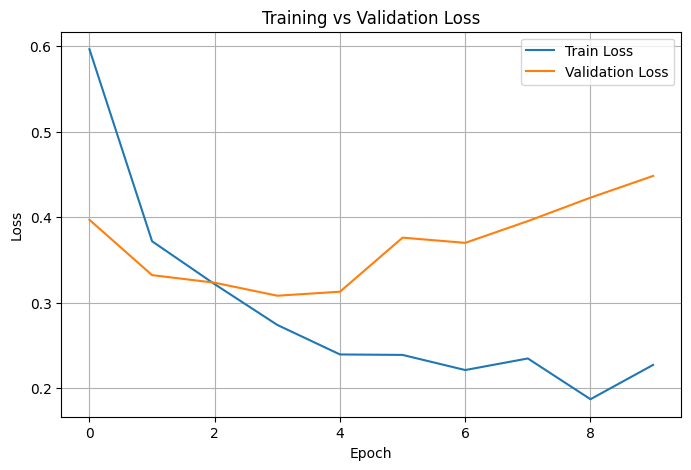

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


### Evaluation + Threshold tuning

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, precision_score,
    recall_score, f1_score, confusion_matrix
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
data = np.load("data_splits_scaled.npz")

X_val  = data["X_val"].astype(np.float32)
y_val  = data["y_val"].astype(int)

X_test = data["X_test"].astype(np.float32)
y_test = data["y_test"].astype(int)

print("VAL shape:", X_val.shape, "TEST shape:", X_test.shape)
print("Fraud rate VAL:", y_val.mean(), "TEST:", y_test.mean())


VAL shape: (42559, 30) TEST shape: (42559, 30)
Fraud rate VAL: 0.0016682722808336662 TEST: 0.0016682722808336662


In [ ]:
model = FraudMLP(input_dim=X_val.shape[1]).to(device)
model.load_state_dict(torch.load("fraud_mlp_trained.pt", map_location=device))
model.eval()

print("Model loaded and set to eval mode")


Model loaded and set to eval mode


In [ ]:
@torch.no_grad()
def predict_proba(model, X, batch_size=4096):
    probs = []
    X = torch.tensor(X, dtype=torch.float32)

    for i in range(0, len(X), batch_size):
        xb = X[i:i+batch_size].to(device)
        logits = model(xb).squeeze(-1)
        p = torch.sigmoid(logits).cpu().numpy()
        probs.append(p)

    return np.concatenate(probs)


In [ ]:
p_val  = predict_proba(model, X_val)
p_test = predict_proba(model, X_test)

print("VAL prob range:", p_val.min(), p_val.max())
print("TEST prob range:", p_test.min(), p_test.max())


VAL prob range: 1.8792014e-06 1.0
TEST prob range: 4.855211e-09 1.0


In [ ]:
pr_auc_val  = average_precision_score(y_val, p_val)
roc_auc_val = roc_auc_score(y_val, p_val)

pr_auc_test  = average_precision_score(y_test, p_test)
roc_auc_test = roc_auc_score(y_test, p_test)

print(f"VAL  PR-AUC: {pr_auc_val:.6f} | ROC-AUC: {roc_auc_val:.6f}")
print(f"TEST PR-AUC: {pr_auc_test:.6f} | ROC-AUC: {roc_auc_test:.6f}")


VAL  PR-AUC: 0.699279 | ROC-AUC: 0.979816
TEST PR-AUC: 0.684684 | ROC-AUC: 0.962296


In [ ]:
prec, rec, thr = precision_recall_curve(y_val, p_val)

f1 = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)

best_idx = np.argmax(f1)
best_thr = thr[best_idx]

print("Best threshold (VAL max F1):", best_thr)
print("VAL Precision:", prec[best_idx])
print("VAL Recall:", rec[best_idx])
print("VAL F1:", f1[best_idx])


Best threshold (VAL max F1): 0.999238
VAL Precision: 0.8983050847457628
VAL Recall: 0.7464788732394366
VAL F1: 0.8153846153841195


In [ ]:
def evaluate_at_threshold(y_true, p, threshold):
    y_pred = (p >= threshold).astype(int)
    P = precision_score(y_true, y_pred, zero_division=0)
    R = recall_score(y_true, y_pred, zero_division=0)
    F = f1_score(y_true, y_pred, zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return P, R, F, cm

val_P, val_R, val_F, val_cm = evaluate_at_threshold(y_val, p_val, best_thr)
test_P, test_R, test_F, test_cm = evaluate_at_threshold(y_test, p_test, best_thr)

print("=== FINAL RESULTS ===")
print("Threshold:", best_thr)

print("\nVAL  Precision:", val_P, "Recall:", val_R, "F1:", val_F)
print("VAL Confusion Matrix:\n", val_cm)

print("\nTEST Precision:", test_P, "Recall:", test_R, "F1:", test_F)
print("TEST Confusion Matrix:\n", test_cm)


=== FINAL RESULTS ===
Threshold: 0.999238

VAL  Precision: 0.8983050847457628 Recall: 0.7464788732394366 F1: 0.8153846153846154
VAL Confusion Matrix:
 [[42482     6]
 [   18    53]]

TEST Precision: 0.7777777777777778 Recall: 0.7887323943661971 F1: 0.7832167832167832
TEST Confusion Matrix:
 [[42472    16]
 [   15    56]]


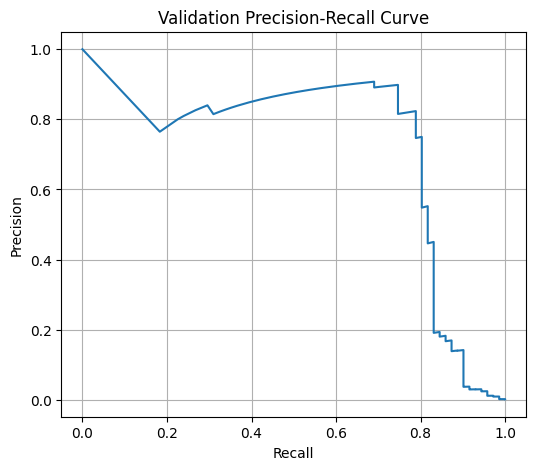

In [ ]:
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Validation Precision-Recall Curve")
plt.grid(True)
plt.show()


### Visualization of the results

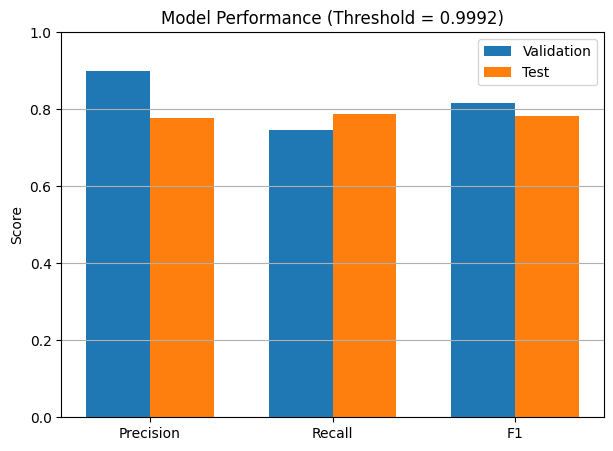

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ["Precision", "Recall", "F1"]
val_scores  = [val_P, val_R, val_F]
test_scores = [test_P, test_R, test_F]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(7,5))
plt.bar(x - width/2, val_scores,  width, label="Validation")
plt.bar(x + width/2, test_scores, width, label="Test")

plt.xticks(x, metrics)
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title(f"Model Performance (Threshold = {best_thr:.4f})")
plt.legend()
plt.grid(True, axis="y")
plt.show()


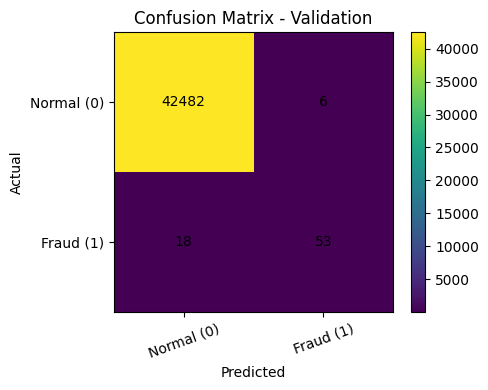

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = val_cm
labels = ["Normal (0)", "Fraud (1)"]

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix - Validation")
plt.xticks([0,1], labels, rotation=20)
plt.yticks([0,1], labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()


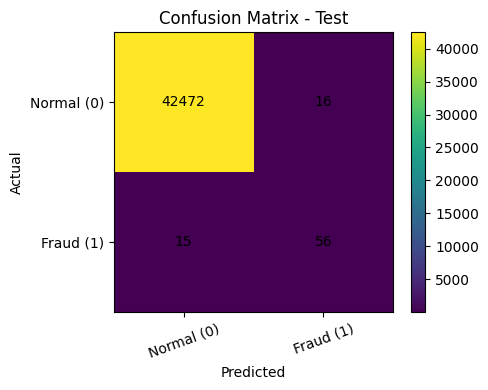

In [ ]:
cm = test_cm
labels = ["Normal (0)", "Fraud (1)"]

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix - Test")
plt.xticks([0,1], labels, rotation=20)
plt.yticks([0,1], labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")

for i in range(2):
    for j in range(2):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.colorbar()
plt.tight_layout()
plt.show()
